In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Custom imports
import sys
sys.path.insert(0, "../")
from plots import interpolation_plot
from models.classifier import ChainedClassifier
from utils import load_model, class_sampler
from attacks import *
device = 'cuda' #'cpu'

def latent_gradient(classifier, source, source_label, start=0, end=1, no_steps=18):
    label = torch.tensor([source_label], dtype=torch.long, device=device)
    data = []
    for epsilon in np.linspace(start, end, no_steps):
        attack = GradientPerturbation(nn.CrossEntropyLoss(), norm='l2', steps=[epsilon], targeted=False)
        data.append(attack.run(source.unsqueeze(0), label, combined))
    return torch.cat(data)

def latent_gradient_mixed(classifier, source, source_label, target_label, steps, no_steps=18, device='cuda'):
    source_label = torch.tensor([source_label], dtype=torch.long, device=device)
    target_label = torch.tensor([target_label], dtype=torch.long, device=device)
    data = []
    for ratio in np.linspace(1, 0, no_steps):
        label = mix_classes(source_label, target_label, ratio).to(device)
        attack = GradientPerturbation(cross_entropy_loss, norm='l2', steps=steps, targeted=True)
        data.append(attack.run(source.unsqueeze(0), label, classifier))
    return torch.cat(data)

def latent_gradient_bisection(classifier, source, source_label, a=10, b=0, no_steps=18):
    data = []
    for ratio in np.linspace(1, 0, no_steps):
        function = LatentGradientValue(classifier, source, source_label)
        c = bisection(function, ratio, a, b, threshold=0.001)
        data.append(function.evaluate(c))
    return torch.cat(data)

torch.manual_seed(0)
generator = load_model(r'..\runs\mnist\ali-mnist', device=device)
classifier = load_model(r'..\runs\mnist\cls-mnist', device=device)
combined = ChainedClassifier(generator, classifier)

# Store samples for each class to dict
d = {c: class_sampler(classifier, generator, c, samples=100, threshold=0.99, device=device) for c in range(10)}

# Gradient descend in latent space

### Percentage of success

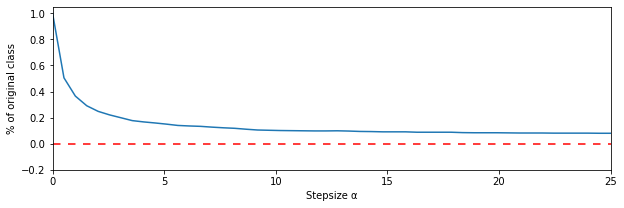

In [2]:
torch.manual_seed(0)
d = {c: class_sampler(classifier, generator, c, samples=100, threshold=0.99, device=device) for c in range(10)}

data = {'epsilon': [], 'labels': [], 'preds': []}
for class_id, imgs in d.items():
    label = torch.full((len(imgs),), class_id, dtype=torch.long, device=device)
    for epsilon in np.linspace(0, 25, 50):
        attack = GradientPerturbation(nn.CrossEntropyLoss(), norm='l2', steps=[epsilon], targeted=False)
        z_perturbed = attack.run(imgs, label, combined)
        data['epsilon'].append(np.full(len(imgs), epsilon))
        data['labels'].append(label.cpu().numpy())
        data['preds'].append(combined(z_perturbed).argmax(dim=1).cpu().numpy())

# Prepare dataset
data = {key: np.concatenate(value) for key, value in data.items()}
df = pd.DataFrame(data)
df['changed'] = df['labels'] == df['preds']
data = df.groupby(['epsilon'])['changed'].mean()

# Create plot
fig= plt.figure(figsize=(10, 3))
ax = fig.add_subplot()
ax.plot(data)
ax.plot(np.full(int(data.index.max())+1, 0), dashes=(5, 5), color='r')
ax.set_yticks(np.linspace(-0.2, 1, 7))
ax.set_ylabel('% of original class')
ax.set_xlabel('Stepsize α')
ax.margins(x=0)

fig.savefig('figures/grad_stepsize_success.png', bbox_inches='tight')

### Untargeted gradient method

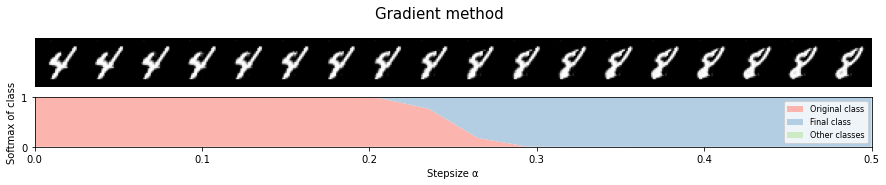

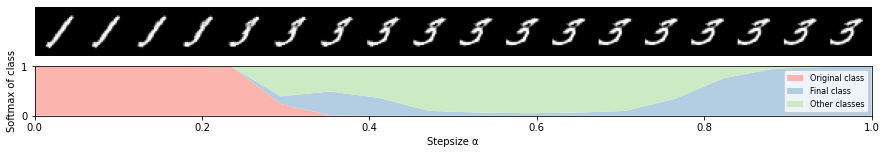

In [3]:
plot_params = {
    'ylabel': 'Softmax of class',
    'xlabel': 'Stepsize α',
    'legend': ['Original class', 'Final class', 'Other classes']
}

source_label = 4
target_label = 8
z = latent_gradient(combined, d[source_label][2], source_label, start=0, end=0.5)
xticks = [f"{i:.1f}" for i in np.linspace(0, 0.5, 6)]
fig1 = interpolation_plot(generator.decode(z), classifier, source_label, target_label, xticks=xticks, **plot_params)
fig1.suptitle('Gradient method', size=15, y=1.1)
fig1.savefig('figures/grad_untargeted_effect1.png', bbox_inches='tight')


source_label = 1
target_label = 3
z = latent_gradient(combined, d[source_label][3], source_label)
xticks = [f"{i:.1f}" for i in np.linspace(0, 1, 6)]
fig1 = interpolation_plot(generator.decode(z), classifier, source_label, target_label, xticks=xticks, **plot_params)
fig1.savefig('figures/grad_untargeted_effect2.png', bbox_inches='tight')

### Gradient method + bisection

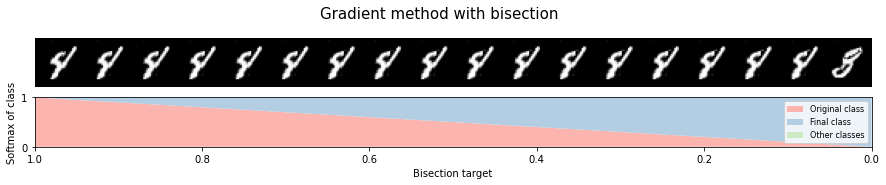

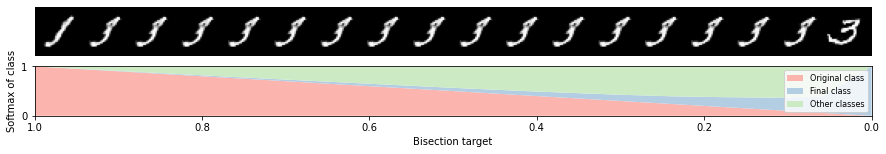

In [4]:
plot_params = {
    'ylabel': 'Softmax of class',
    'xlabel': 'Bisection target',
    'legend': ['Original class', 'Final class', 'Other classes']
}

source_label = 4
target_label = 8
z = latent_gradient_bisection(combined, d[source_label][2], source_label, a=5)
xticks = [f"{i:.1f}" for i in np.linspace(1, 0, 6)]
fig1 = interpolation_plot(generator.decode(z), classifier, source_label, target_label, xticks=xticks, **plot_params)
fig1.suptitle('Gradient method with bisection', size=15, y=1.1)
fig1.savefig('figures/grad_bisection_effect1.png', bbox_inches='tight')


source_label = 1
target_label = 3
z = latent_gradient_bisection(combined, d[source_label][3], source_label)
xticks = [f"{i:.1f}" for i in np.linspace(1, 0, 6)]
fig1 = interpolation_plot(generator.decode(z), classifier, source_label, target_label, xticks=xticks, **plot_params)
fig1.savefig('figures/grad_bisection_effect2.png', bbox_inches='tight')

### Targeted gradient method

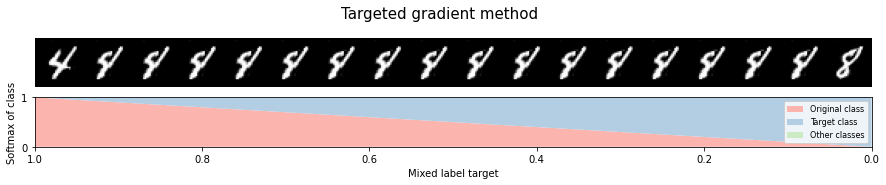

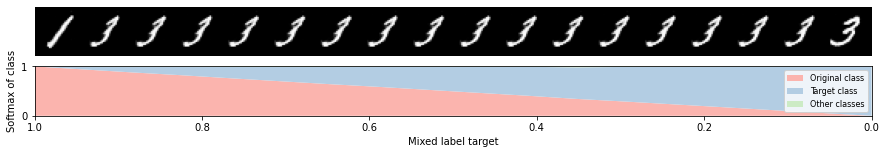

In [5]:
plot_params = {
    'ylabel': 'Softmax of class',
    'xlabel': 'Mixed label target',
    'legend': ['Original class', 'Target class', 'Other classes']
}

source_label = 4
target_label = 8
steps = SchedulerExponential(initial=0.1, gamma=0.05, steps=200)
z = latent_gradient_mixed(combined, d[source_label][2], source_label, target_label, steps)
xticks = [f"{i:.1f}" for i in np.linspace(1, 0, 6)]
fig1 = interpolation_plot(generator.decode(z), classifier, source_label, target_label, xticks=xticks, **plot_params)
fig1.suptitle('Targeted gradient method', size=15, y=1.1)
fig1.savefig('figures/grad_targeted_effect1.png', bbox_inches='tight')


source_label = 1
target_label = 3
steps = SchedulerExponential(initial=0.1, gamma=0.05, steps=200)
z = latent_gradient_mixed(combined, d[source_label][3], source_label, target_label, steps)
xticks = [f"{i:.1f}" for i in np.linspace(1, 0, 6)]
fig1 = interpolation_plot(generator.decode(z), classifier, source_label, target_label, xticks=xticks, **plot_params)
fig1.savefig('figures/grad_targeted_effect2.png', bbox_inches='tight')